# Kalman Filter Implementation

References:
- https://www.mathworks.com/help/fusion/ug/pose-estimation-from-asynchronous-sensors.html
- https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
- https://proj.org/en/stable/about.html
- https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates
- https://en.wikipedia.org/wiki/Geodetic_coordinates
- https://en.wikipedia.org/wiki/World_Geodetic_System

Method (Steps):
1. Convert GPS long/lat measurements to relative xy-coords in meters
2. Integrate Gyro/Accel to get yaw angle (z-axis) and forward speed (y-axis), respectively
3. Use INS equations and another integration to find xy-trajectory for Gyro/Accel measurements
4. Plot measurements of $xy$ and $\theta$ across time for each sensor
5. Implement EKF
6. Use EKF to fuse sensors
7. Analyse results

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
stat_acc_df = pd.read_csv("../data/stationary_acc.csv")
stat_gyr_df = pd.read_csv("../data/stationary_gyr.csv")
traj_acc_df = pd.read_csv("../data/traj_acc.csv")
traj_gyr_df = pd.read_csv("../data/traj_gyr.csv")
traj_gps_df = pd.read_csv("../data/traj_gps.csv")
traj_truth_df = pd.read_csv("../data/traj_truth.csv")

In [19]:
traj_acc_df.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
0,0.0225,-0.299,-0.282,9.57
1,0.0246,-0.370,-0.282,9.66
2,0.0267,-0.414,-0.277,9.64
3,0.0289,-0.446,-0.191,9.67
4,0.0310,-0.455,-0.153,9.73


In [20]:
traj_gyr_df.head()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
0,0.0310,0.00122,-0.000305,-0.001110
1,0.0332,0.00122,-0.001530,-0.001110
2,0.0353,-0.00122,0.000916,0.000111
3,0.0374,-0.00244,0.000916,0.000264
4,0.0396,0.00000,-0.002750,0.000111


In [ ]:
traj_gps_df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,0.000000,45.447264,-73.798053,51.816190,0.0,61.189362,24.632000,9.429768
1,1.948017,45.446880,-73.796762,22.286429,0.0,61.189362,14.082784,14.651149
2,3.043338,45.446932,-73.796780,22.176985,0.0,61.189362,4.277642,27.384563
3,4.052077,45.446939,-73.796782,16.394296,0.0,61.189362,9.414026,15.854093
4,5.085355,45.446936,-73.796781,15.293201,0.0,61.189362,9.205843,12.037631


In [18]:
traj_gps_df.tail()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
786,793.605199,45.446937,-73.79683,20.123425,0.001600,65.843979,1.667726,1.650350
787,794.605227,45.446937,-73.79683,20.197818,0.001356,65.966217,1.851725,1.856987
788,795.605238,45.446937,-73.79683,20.164633,0.001067,65.933029,1.699418,2.054355
789,796.605272,45.446937,-73.79683,20.172889,0.000466,65.909470,1.564583,2.236105
790,797.605318,45.446937,-73.79683,20.183647,0.000351,65.959579,1.466302,2.402915


In [21]:
traj_truth_df.head()

,Latitude (°),Longitude (°)
0,45.447014,-73.796857
1,45.447038,-73.796779
2,45.447117,-73.796843
3,45.447164,-73.796908
4,45.447196,-73.796924


In [40]:
traj_truth_lat_vec = traj_truth_df.loc[:, 'Latitude (°)'].to_numpy()
traj_truth_long_vec = traj_truth_df.loc[:, 'Longitude (°)'].to_numpy()
traj_gps_lat_vec = traj_gps_df.loc[:, 'Latitude (°)'].to_numpy()
traj_gps_long_vec = traj_gps_df.loc[:, 'Longitude (°)'].to_numpy()
traj_gps_h_vec = traj_gps_df.loc[:, 'Height (m)'].to_numpy()

In [41]:
type(traj_gps_h_vec)

numpy.ndarray

Text(0, 0.5, 'Latitude (°)')

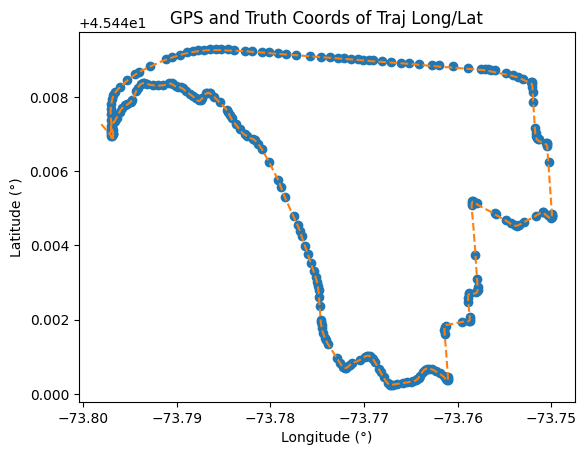

In [42]:
plt.plot(traj_truth_long_vec, traj_truth_lat_vec, 'o')
plt.plot(traj_gps_long_vec, traj_gps_lat_vec, '--')
plt.title("GPS and Truth Coords of Traj Long/Lat")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")

## Preprocessing GPS Data to Local Coordinates

First step would be to convert GPS long/lat measurements to relative xy-coords in meters.

Since IMU is in ENU coords the conversion method is as follows:
- Convert geodetic coords to ECEF coords
- Convert ECEF coords to local ENU coords 

The Prime Vertical Radius of Curvature is
$$\frac{a^2}{\sqrt{a^2\cos^2\phi + b^2\sin^2\phi}},$$
where $a = 6378137.0m$ and $b = 6356752.314245 m$ are the semi-major axis and semi-minor axis, respectively. $\phi$ is geodetic latitude and $\lambda$ is geodetic longitude.

In [27]:
def prime_vert_radius_curvature(lat, a=6378137.0, b=6356752.314245):
    phi = lat
    return a**2 / np.sqrt(a**2 * np.cos(phi)**2 + b**2 * np.sin(phi)**2)

In [25]:
prime_vert_radius_curvature(45)

np.float64(6393650.76230695)

In [28]:
def geodet_to_ecef(lat, long, h):
    a = 6378137.0
    b = 6356752.314245
    phi = lat
    lmbd = long
    N = prime_vert_radius_curvature(lat)
    x = (N + h) * np.cos(phi) * np.cos(lmbd)
    y = (N + h) * np.cos(phi) * np.sin(lmbd)
    z = (b**2 / a**2 * N + h) * np.sin(phi)
    return x, y, z

In [45]:
def ecef_enu(lat_p, long_p, h_p, lat_r, long_r, h_r):
    phi_p = lat_p
    lmbd_p = long_p
    phi_r = lat_r
    lmbd_r = long_r
    R = np.transpose(np.array([[-np.sin(lmbd_r), -np.sin(phi_r)*np.cos(lmbd_r), np.cos(phi_r)*np.cos(lmbd_r)],
                 [np.cos(lmbd_r), -np.sin(phi_r)*np.sin(lmbd_r), np.cos(phi_r)*np.sin(lmbd_r)],
                 [0, np.cos(phi_r), np.sin(phi_r)]]))

    x_r, y_r, z_r = geodet_to_ecef(lat_r, long_r, h_r)
    x_p, y_p, z_p = geodet_to_ecef(lat_p, long_p, h_p)
    delta = np.array([x_p - x_r, y_p - y_r, z_p - z_r])
    delta.reshape((delta.shape[0], 1))
    enu = R @ delta
    return enu[0], enu[1], enu[2]

In [46]:
lat_r = traj_gps_lat_vec[0]
long_r = traj_gps_long_vec[0]
h_r = traj_gps_h_vec[0]
lat_p = traj_gps_lat_vec[-1]
long_p  = traj_gps_long_vec[-1]
h_p = traj_gps_h_vec[-1]
f"ref: ({lat_r}, {long_r}, {h_r}); p: ({lat_p}, {long_p}, {h_p})"

'ref: (45.4472644, -73.7980526, 51.81619023); p: (45.44693658, -73.79682967, 20.1836471)'

In [48]:
enu_res = ecef_enu(lat_p, long_p, h_p, lat_r, long_r, h_r)
f"x: {enu_res[0]}m, y: {enu_res[1]}, z: {enu_res[2]}"

'x: 829.2224257298756m, y: -2097.1798054208466, z: -32.02993400553231'